# Money Mules (детекция «дропперов»)

Мы — Data Science команда в крупном банке. Департамент финансового мониторинга (Compliance) столкнулся с проблемой: через банк проходят незаконные транзакции с использованием счетов «дропперов» (Money Mules). Это люди, которые предоставляют свои счета для транзита украденных денег. 

Обычные правила (rules-based approach) дают слишком много ложных срабатываний, блокируя честных клиентов, которые просто активно пользуются счетом.

Моя задача:     
- Провести разведочный анализ данных (EDA) по транзакционной активности.    
- Понять отличия поведения «дропперов» (Is_Mule = 1) от обычных клиентов (Is_Mule = 0)    .
- Подготовить выводы и гипотезы для построения модели.

Особенности данныхМнеам доступны данные о возрасте счета, объемах транзакций, частоте переводов и остатках на конец дня. 

Внимание: Классы несбалансированы (мошенников значительно меньше, чем честных клиентов).

## 1. Загрузка данных и первичный осмотр

**Import numpy и pandas**

In [4]:
import numpy as np
import pandas as pd

**Import библиотек визуализации и добавить %matplotlib inline.**

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

**Прочитать CSV-файл как DataFrame с именем df**

In [9]:
df = pd.read_csv(r'C:\Users\baizh\Downloads\money_mule_dataset.csv')

In [10]:
df.head

<bound method NDFrame.head of        Customer_ID  Account_Age_Days  Transaction_Volume_USD  \
0        MULE_1372              55.0                52097.27   
1       CUST_26636             945.0                 1471.92   
2        CUST_9210            2952.0                 1721.02   
3       CUST_13653            2911.0                 1570.88   
4       CUST_23363            1136.0                 1971.88   
...            ...               ...                     ...   
49995   CUST_10832            2439.0                 2100.22   
49996   TRADER_771            1970.0                44989.64   
49997  TRADER_5369            1527.0                48335.77   
49998   CUST_12575            2378.0                 1631.87   
49999   CUST_29396            1429.0                 2249.01   

       Avg_Time_Between_Trans_Min  Flags_Last_6M  Avg_End_Day_Balance  Is_Mule  
0                            11.0            1.0               107.47      1.0  
1                          9221.0      

**Проверьте info() по df**

In [11]:
df.info

<bound method DataFrame.info of        Customer_ID  Account_Age_Days  Transaction_Volume_USD  \
0        MULE_1372              55.0                52097.27   
1       CUST_26636             945.0                 1471.92   
2        CUST_9210            2952.0                 1721.02   
3       CUST_13653            2911.0                 1570.88   
4       CUST_23363            1136.0                 1971.88   
...            ...               ...                     ...   
49995   CUST_10832            2439.0                 2100.22   
49996   TRADER_771            1970.0                44989.64   
49997  TRADER_5369            1527.0                48335.77   
49998   CUST_12575            2378.0                 1631.87   
49999   CUST_29396            1429.0                 2249.01   

       Avg_Time_Between_Trans_Min  Flags_Last_6M  Avg_End_Day_Balance  Is_Mule  
0                            11.0            1.0               107.47      1.0  
1                          9221.0    

**Выведем количество строк и столбцов в датасете.**

In [12]:
df.shape

(50000, 7)

**Определим, в каких столбцах и сколько пропущенных значений.**

In [13]:
df.isnull().sum()

Customer_ID                   485
Account_Age_Days              509
Transaction_Volume_USD        529
Avg_Time_Between_Trans_Min    461
Flags_Last_6M                 520
Avg_End_Day_Balance           534
Is_Mule                       477
dtype: int64

## 2. Базовая описательная статистика

**Получим общую описательную статистику по числовым признакам.**

In [15]:
df.describe(include='number')

,Account_Age_Days,Transaction_Volume_USD,Avg_Time_Between_Trans_Min,Flags_Last_6M,Avg_End_Day_Balance,Is_Mule
count,49491.000000,49471.000000,49539.000000,49480.000000,49466.000000,49523.000000
mean,1417.342971,11370.293603,4024.368457,0.119038,6239.109908,0.050098
std,841.009039,19355.028693,3253.771664,0.399753,4464.139755,0.218149
min,1.000000,109.490000,1.000000,0.000000,0.030000,0.000000
25%,715.000000,1753.835000,691.000000,0.000000,3970.402500,0.000000
50%,1387.000000,2155.880000,3781.000000,0.000000,5212.235000,0.000000
75%,2084.000000,2760.890000,6874.500000,0.000000,6656.327500,0.000000
max,2999.000000,98015.150000,9999.000000,3.000000,32321.590000,1.000000


**Анализ целевого признака Is_Mule**

Посмотрим распределение целевого признака `Is_Mule` (количество и доли классов).

In [18]:
df['Is_Mule'].value_counts(dropna=False)


Is_Mule
0.0    47042
1.0     2481
NaN      477
Name: count, dtype: int64

In [19]:
df['Is_Mule'].value_counts(dropna=False, normalize=True) * 100

Is_Mule
0.0    94.084
1.0     4.962
NaN     0.954
Name: proportion, dtype: float64

**Визуализация распределения классов**

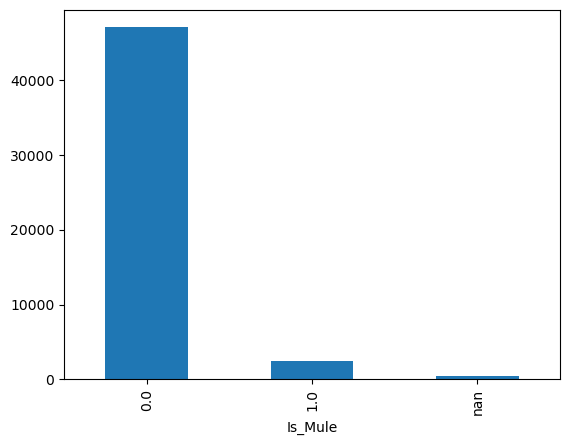

In [22]:
df['Is_Mule'].value_counts(dropna=False).plot(kind='bar')
plt.show()

## 3. Очистка целевого признака

**Удалим строки с пропусками в `Is_Mule`**

In [12]:
# пересохранить как df

In [23]:
df = df.dropna(subset=['Is_Mule'])

**Приведем столбец `Is_Mule` к типу `int` (0 или 1).**

In [24]:
df['Is_Mule'].value_counts()

Is_Mule
0.0    47042
1.0     2481
Name: count, dtype: int64

**Перепроверяем баланс классов после очистки**

In [25]:
df['Is_Mule'].value_counts(normalize=True)

Is_Mule
0.0    0.949902
1.0    0.050098
Name: proportion, dtype: float64

**Выбор числовых признаков для анализа**

Создаем список основных числовых признаков (без ID и таргета) для дальнейшего EDA.

In [30]:
list1 = df.columns.drop(['Customer_ID','Is_Mule']).tolist()
list1

['Account_Age_Days',
 'Transaction_Volume_USD',
 'Avg_Time_Between_Trans_Min',
 'Flags_Last_6M',
 'Avg_End_Day_Balance']

**Описательная статистика по ключевым числовым признакам**

Выведем статистику только по выбранным числовым признакам.

In [33]:
df[list1].describe(include='number')

,Account_Age_Days,Transaction_Volume_USD,Avg_Time_Between_Trans_Min,Flags_Last_6M,Avg_End_Day_Balance
count,49023.000000,49001.000000,49067.000000,49009.000000,48993.000000
mean,1418.189034,11373.568486,4023.933805,0.118937,6239.112066
std,841.335219,19356.834045,3254.144185,0.399756,4465.087121
min,1.000000,109.490000,1.000000,0.000000,0.030000
25%,716.000000,1753.700000,690.000000,0.000000,3969.460000
50%,1388.000000,2155.670000,3781.000000,0.000000,5212.100000
75%,2086.000000,2761.430000,6874.000000,0.000000,6657.280000
max,2999.000000,98015.150000,9999.000000,3.000000,32321.590000


## 4. Univariate EDA: распределения признаков

**Построим гистограммы для каждого числового признака, чтобы увидеть форму распределения и возможные выбросы.**

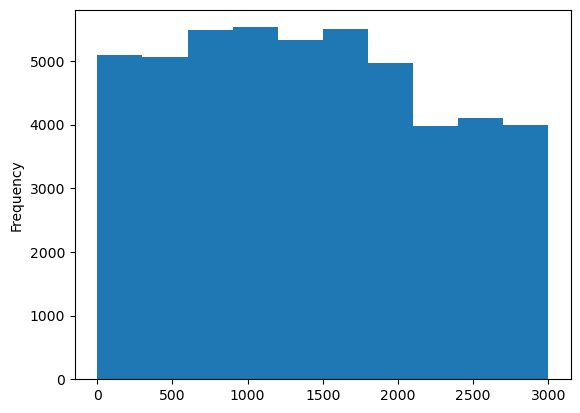

In [39]:
df[list1]['Account_Age_Days'].plot(kind='hist')
plt.show()

**Boxplot для выявления выбросов**

Построим boxplot для каждого числового признака, чтобы увидеть выбросы.

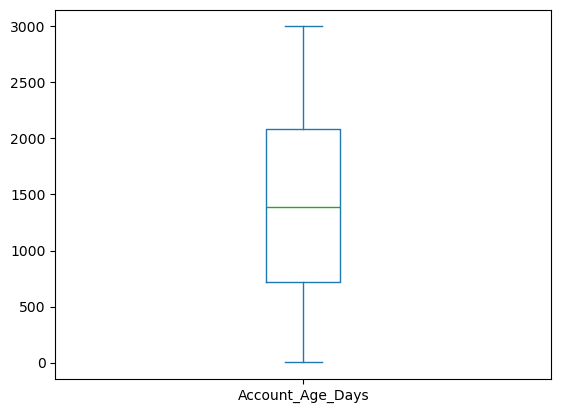

In [40]:
df[list1]['Account_Age_Days'].plot(kind='box')
plt.show()

## 5. Target-aware EDA: сравнение признаков по классам Is_Mule

Сравним описательную статистику по каждому признаку в разрезе классов: `Is_Mule = 0` и `Is_Mule = 1`.


In [41]:
print("=== Account_Age_Days по классам Is_Mule ===")
df.groupby('Is_Mule')['Account_Age_Days'].describe()

=== Account_Age_Days по классам Is_Mule ===


,count,mean,std,min,25%,50%,75%,max
Is_Mule,,,,,,,,
0.0,46567.0,1491.404192,798.851152,100.0,818.00,1457.0,2133.0,2999.0
1.0,2456.0,29.992671,17.100159,1.0,14.75,30.5,45.0,59.0


**Средние значения признаков по классам**

Сравним средние значения числовых признаков для обычных клиентов и «дропперов».

In [45]:
df.groupby('Is_Mule')[list1].mean()

,Account_Age_Days,Transaction_Volume_USD,Avg_Time_Between_Trans_Min,Flags_Last_6M,Avg_End_Day_Balance
Is_Mule,,,,,
0.0,1491.404192,9591.603555,4236.196872,0.083659,6563.320968
1.0,29.992671,45231.629502,7.568413,0.789066,101.170151


## Boxplot по классам

Построим boxplot для каждого признака с разделением по классам `Is_Mule`.

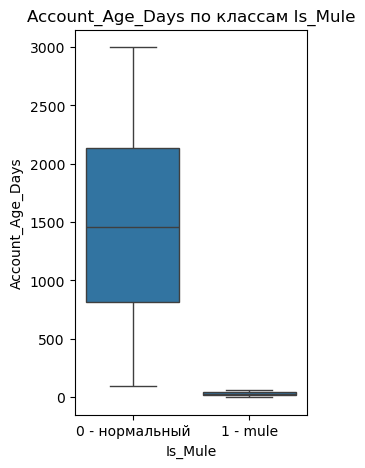

In [48]:
plt.figure(figsize=(3,5))
sns.boxplot(x='Is_Mule', y='Account_Age_Days', data=df)

plt.xticks([0,1], ['0 - нормальный', '1 - mule'])
plt.title('Account_Age_Days по классам Is_Mule')
plt.show()

## 6. Корреляционный анализ

Построим корреляционную матрицу для числовых признаков и таргета `Is_Mule`.

In [50]:
corr = df[list1 + ['Is_Mule']].corr()
corr

,Account_Age_Days,Transaction_Volume_USD,Avg_Time_Between_Trans_Min,Flags_Last_6M,Avg_End_Day_Balance,Is_Mule
Account_Age_Days,1.000000,-0.292533,0.196110,-0.170625,-0.004613,-0.378932
Transaction_Volume_USD,-0.292533,1.000000,-0.597997,0.315675,0.568678,0.401283
Avg_Time_Between_Trans_Min,0.196110,-0.597997,1.000000,-0.210008,-0.340687,-0.283741
Flags_Last_6M,-0.170625,0.315675,-0.210008,1.000000,0.025856,0.384629
Avg_End_Day_Balance,-0.004613,0.568678,-0.340687,0.025856,1.000000,-0.315935
Is_Mule,-0.378932,0.401283,-0.283741,0.384629,-0.315935,1.000000


**Визуализация корреляционной матрицы**

Отобразим корреляционную матрицу в виде тепловой карты (heatmap).

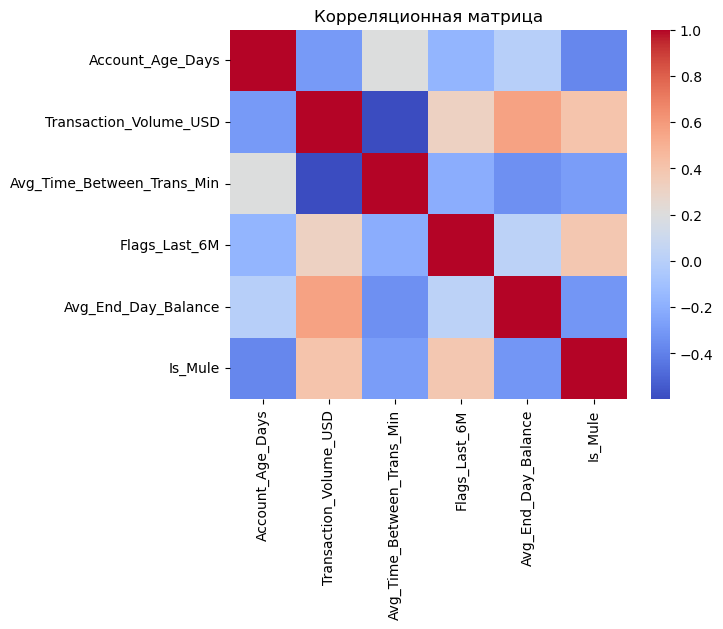

In [54]:
corr = df.corr(numeric_only=True)
sns.heatmap(corr, annot=False, cmap='coolwarm', fmt=".2f")
plt.title('Корреляционная матрица')
plt.show()

## 7. Взаимосвязи признаков: scatter-графики

Построим scatter-график для пары признаков `Account_Age_Days` и `Transaction_Volume_USD` с выделением классов `Is_Mule`.

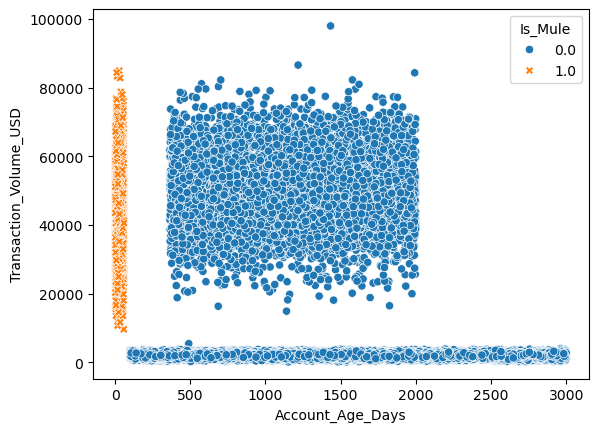

In [57]:
sns.scatterplot(data=df, x='Account_Age_Days', y='Transaction_Volume_USD', hue='Is_Mule', style= 'Is_Mule')
plt.show()

## Взаимосвязь остатка и объёма

Построим scatter-график для пары `Avg_End_Day_Balance` и `Transaction_Volume_USD` с выделением классов.

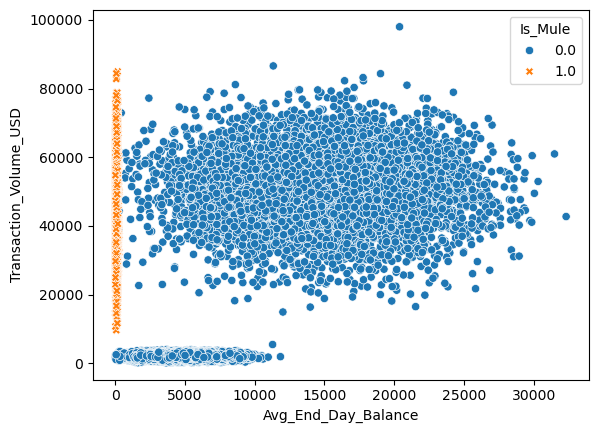

In [61]:
sns.scatterplot(data=df, x='Avg_End_Day_Balance', y='Transaction_Volume_USD', hue='Is_Mule', style= 'Is_Mule')
plt.show()

## 8. Обработка пропусков и подготовка данных

Создадим очищенную версию датасета `df_clean`, удалив строки с пропусками в ключевых числовых признаках.

In [65]:
df_clean=df.dropna(subset=numeric_features)
df_clean.shape

(47054, 7)

**Приведение типов признаков**

In [69]:
df_clean['Flags_Last_6M'] = df['Flags_Last_6M'].astype(int)
df_clean['Flags_Last_6M'].value_counts()

C:\Users\baizh\AppData\Local\Temp\ipykernel_1344\2079111132.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['Flags_Last_6M'] = df['Flags_Last_6M'].astype(int)


Flags_Last_6M
0    42516
1     3694
2      616
3      228
Name: count, dtype: int64

## 9. Создание новых производных признаков

Создайте новые признаки:
- `Volume_per_Day` = `Transaction_Volume_USD` / (`Account_Age_Days` + 1)
- `Balance_to_Volume` = `Avg_End_Day_Balance` / (`Transaction_Volume_USD` + 1)

In [29]:
# Создаём производные признаки

In [74]:
df_clean['Volume_per_Day'] = df['Transaction_Volume_USD'] / (df['Account_Age_Days'] + 1)
df_clean['Balance_to_Volume'] = df['Avg_End_Day_Balance'] / (df['Transaction_Volume_USD'] + 1)

C:\Users\baizh\AppData\Local\Temp\ipykernel_1344\187350474.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['Volume_per_Day'] = df['Transaction_Volume_USD'] / (df['Account_Age_Days'] + 1)
C:\Users\baizh\AppData\Local\Temp\ipykernel_1344\187350474.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['Balance_to_Volume'] = df['Avg_End_Day_Balance'] / (df['Transaction_Volume_USD'] + 1)


In [75]:
df_clean[['Volume_per_Day', 'Balance_to_Volume']].describe()


,Volume_per_Day,Balance_to_Volume
count,47054.000000,4.705400e+04
mean,148.352836,2.214807e+00
std,1018.900506,1.541169e+00
min,0.074481,5.908140e-07
25%,0.947561,1.247200e+00
50%,1.677269,2.201322e+00
75%,6.972659,3.026328e+00
max,34251.325000,3.696628e+01


**Сравнение новых признаков по классам**

Сравним распределения `Volume_per_Day` и `Balance_to_Volume` для обычных клиентов и «дропперов».

In [76]:
df_clean.groupby('Is_Mule')[['Volume_per_Day', 'Balance_to_Volume']].describe().T

Is_Mule                           0.0           1.0
Volume_per_Day    count  44699.000000  2.355000e+03
                  mean      10.239297  2.769812e+03
                  std       21.835498  3.674918e+03
                  min        0.074481  1.629941e+02
                  25%        0.926370  9.665169e+02
                  50%        1.555805  1.460794e+03
                  75%        4.732601  2.943800e+03
                  max      199.442703  3.425132e+04
Balance_to_Volume count  44699.000000  2.355000e+03
                  mean       2.331368  2.428459e-03
                  std        1.492941  1.468876e-03
                  min        0.002236  5.908140e-07
                  25%        1.470571  1.411069e-03
                  50%        2.275541  2.232787e-03
                  75%        3.080421  3.125641e-03
                  max       36.966281  1.331781e-02

## 10. Итоговые выводы по EDA

In [78]:
# 1. Таргет сильно несбалансирован: примерно ~95% обычных клиентов и ~5% дропперов. Для модели потребуется учёт дисбаланса.
# 2. Чем дропперы отличаются: 
                          # аккаунты почти всегда «свежие» (малый Account_Age_Days);
                          # суммы операций большие и более «сконцентрированные»;
                          # чаще есть флаги (Flags_Last_6M);
                          # остатки на счетах низкие по отношению к объёму операций;
                          # новые признаки подтверждают аномальное поведение:
                          # Volume_per_Day выше, Balance_to_Volume ниже.
# 3️. Гипотезы о поведении дропперов:
                          # аккаунт создаётся недавно → быстро проводятся крупные транзакции;
                          # деньги на счёте не задерживаются;
                          # активность выглядит резкой и «неестественной» для обычного клиента.
# 4. Полезные признаки для модели:
                          # Account_Age_Days, Transaction_Volume_USD,
                          # Flags_Last_6M, Avg_End_Day_Balance,
                          # а также производные Volume_per_Day и Balance_to_Volume.